In [1]:
# Loading necessary modlules

import os 
import os.path as osp
import itertools
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as pl
pl.rcParams['axes.labelsize'] = 16
pl.rcParams['axes.titlesize'] = 16

import pandas as pd
import seaborn as sns
pl.style.use('seaborn')
import timeit

from astropy.stats import bayesian_blocks
from scipy.stats import binned_statistic,norm, bayes_mvs
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import gaussian_kde

from sklearn.linear_model import LinearRegression
from astropy.wcs import WCS # my additional package
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from scipy.stats import gaussian_kde
import xgboost
from pprint import pprint
pl.style.use('seaborn-white')
%matplotlib inline

In [2]:
# Defining function

def Preprocessing(filename, task='R', N=1000000):
    '''This function processes the data for a given task and returns the processed data.
    parameters:
    filename - path to the fits file
    task - process to be executed, default is Classification (c,C) another options is Regression (r,R)
    N - number of data point to use for data points
    
    returns:
    Arrays of data split into training and testng data depending on the task at hand.
    '''
    fp = pf.open(filename, memmap=True)
    data = fp[1].data
    fp.close()
    
    #Change the value of n to select only a subset of the data
    data = data[:N] # Only looking for 1000000 points
    
    #df = df.iloc[:n]
    ID = data['objID']
    u = data['dered_u']
    g = data['dered_g']
    r = data['dered_r']
    i = data['dered_i']
    z = data['dered_z']
    w1 = data['W1mproPM']
    w2 = data['W2mproPM']
    
    # use color as features – color is the difference of 
    # magnitudes between two different filter bands.
    # features: [u-g, g-r, r-i, i-z, z-w1, w1-w2]
    
    
     # feaures
    x = np.vstack([np.array(r), 
                   np.array(u) - np.array(g), 
                   np.array(g) - np.array(r), 
                   np.array(r) - np.array(i), 
                   np.array(i) - np.array(z), 
                   np.array(z) - np.array(w1), 
                   np.array(w1) - np.array(w2)]).T
    
    
    # keep track of all indices
    indices = np.arange(x.shape[0])
    
    # Regression
    if task == 'r' or task == 'R':
        # conditions on magnitude values, #the sources detected and making sure that there is a reasonable measurement.
        cond_u = indices[np.logical_and(u>13.0,u<20.0)]
        cond_g = indices[np.logical_and(g>14.0,g<22.2)]
        cond_r = indices[np.logical_and(r>14.0,r<22.2)]
        cond_i = indices[np.logical_and(i>14.0,i<21.3)]
        cond_z = indices[np.logical_and(z>12.0,z<20.5)]
        
        # index of where all conditions are true
        cond_u_g = cond_u[np.in1d(cond_u,cond_g)]
        cond_u_g_r = cond_u_g[np.in1d(cond_u_g,cond_r)]
        cond_u_g_r_i = cond_u_g_r[np.in1d(cond_u_g_r,cond_i)]
        cond_u_g_r_i_z = cond_u_g_r_i[np.in1d(cond_u_g_r_i, cond_z)]
    
        # get values that satisfy the conditions
        class_0 = np.array([data['specclass'][i] for i in cond_u_g_r_i_z])
        class_1 = np.array([data['specsubclass'][i] for i in cond_u_g_r_i_z])
        redshift = np.array([data['zspec'][i] for i in cond_u_g_r_i_z])
        #warning = np.array([data['zspecwarning'][i] for i in cond_ug_r_i_z]) because all the values are equal to zeros, 
        # we do not need this value.
        
        # gather all rows
        x_data = np.zeros((len(cond_u_g_r_i_z),x.shape[1]))
        for i in range(len(cond_u_g_r_i_z)):
            x_data[i] = x[cond_u_g_r_i_z[i]]
        
        # keep track of all indices
        indices = np.arange(x_data.shape[0])
        
        # for regression we only use GALAXY and QSO data
        ix = np.where(class_0 != 'STAR')[0]
        i_gal = indices[class_0 == 'GALAXY'] # index of GALAXY class
        print('Number of galaxies: {}'.format(len(i_gal)))
        
        i_qso = indices[class_0 == 'QSO'] # index of QSO class
        print('\n\nNumber of quasars: {}'.format(len(i_qso)))
        
        y_z = redshift
        #x_train, x_test, y_ztrain, y_ztest, i_train, i_test = train_test_split(x_data[ix], y_z[ix], ix, test_size=0.25) #splitting data into 75% and 25% train and test datasets, respectively
        
        return x_data, y_z, i_gal, i_qso

In [3]:
def photo_z_stats(zpredicted,ztrue):
    '''This function takes the arrays of the predicted and true redshift values
    and returns values used for evaluation of the photo-z regression process
            
    parameters:
    zpredicted - predicted redshift values from the algorithm
    ztrue - ground truth redshift values 
            
    returns:
    del_z_norm - normalized redshift estimation error
    del_z_mean - mean value of the normalized redshift estimation error (a.k.a bias)
    del_z_median - median value of the normalized redshift estimation error
    del_z_RMS - root-mean-square value of the normalized redshift estimation error (a.k.a precision)
    del_z_MAD - median-absolute-deviation value of the normalized redshift estimation error
    del_z_NMAD - normalized-median-absolute-deviation (PS: less sensitive to outliers than the RMS, thus mostly preferred value of precision )
    '''
    # evaluation measures used for photo-z regression
    del_z_norm = (zpredicted-ztrue)/(1+ztrue) # normalized redshift estimation error

    del_z_mean = np.mean(del_z_norm)

    del_z_median = np.median(del_z_norm)

    del_z_RMS = np.std(del_z_norm)

    del_z_MAD = np.median(abs(del_z_norm - np.median(del_z_median)))

    del_z_NMAD = 1.4826*del_z_MAD 

    print('delta(z)_mean = {}; delta(z)_median = {}; sigma(delta(z)) = {}; nmad(delta(z)) = {}'.format(del_z_mean,del_z_median,del_z_RMS,del_z_NMAD))
            
    return del_z_norm, del_z_mean, del_z_median, del_z_RMS, del_z_MAD, del_z_NMAD

In [4]:
def outliers_fractions(delta_z_norm, del_z_NMAD):
    '''This function calculation a fraction of sources with large error for a given N.
    formula given as: normalized redshift estimation errors with values greater than 
    N times the standard deviation of the normalized redshift estimation errors.
    
    parameters:
    del_z_norm - normalized redshift estimation error
    del_z_RMS - root-mean-square value of the normalized redshift estimation error (a.k.a precision)

    returns:
    N sigma values
    '''
    sig_1 = abs(delta_z_norm) > (1. * del_z_NMAD)
    sigma_1 = (float(len(delta_z_norm[sig_1]))/len(delta_z_norm))*100.

    sig_2 = abs(delta_z_norm) > (2. * del_z_NMAD)
    sigma_2 = (float(len(delta_z_norm[sig_2]))/len(delta_z_norm))*100.

    sig_3 = abs(delta_z_norm) > (3.*del_z_NMAD)
    sigma_3 = (float(len(delta_z_norm[sig_3]))/len(delta_z_norm))*100.
    
    sig_5 = abs(delta_z_norm) > 0.05
    sigma_5 = (float(len(delta_z_norm[sig_5]))/len(delta_z_norm))*100.
    
    sig_10 = abs(delta_z_norm) > 0.1
    sigma_10 = (float(len(delta_z_norm[sig_10]))/len(delta_z_norm))*100.
    
    sig_15 = abs(delta_z_norm) > 0.15
    sigma_15 = (float(len(delta_z_norm[sig_15]))/len(delta_z_norm))*100.

    print('sigma1 = {}; sigma2 = {}; sigma3 = {}; sigma5 = {}; sigma10 = {}; sigma15 = {}'.format(sigma_1,sigma_2,sigma_3,sigma_5, sigma_10, sigma_15))
    
    return sigma_1,sigma_2,sigma_3, sigma_5, sigma_10, sigma_15

In [5]:
def regressor(rg,data,labels, i_gal, i_qso, name='', cl='', lim=[]):
    '''This function gives the plot of photo-z estimates of the given regressor
    parameters:
    rg - the algorithm to perform regression
    x_tr - training dataset
    x_t - test dataset
    y_ztr - photo-z training data
    y_zt - photo-z test data
    i_train - indices of training data 
    i_test - indices of test data
    i_gal - index of GALAXY specclass
    i_qso - index of QSO specclass
    name - name of the regressor
    cl - sources class ('GALAXY','QSO')
    lim - axis limits, default [0.0,0.5] ('GALAXY') ; [0.0,3.5] (QSO)
    
    returns:
    mean of the separation of the predicted and the true redshift.
    median of the separation of the predicted and the true redshift.
    rms of the separation of the predicted and the true redshift.
    nmad of the separation of the predicted and the true redshift.
    
    sigma (1*sigma, 2*sigma, 3*sigma and 4*sigma) of the separation of the predicted and the true redshift.
    plot of predicted and true redshift.
    '''
    
    
    if cl !='' and cl=='GALAXY':
       
        data = data[i_gal]
        labels = labels[i_gal]
        
        x_train, x_test, y_ztrain, y_ztest, i_train, i_test = train_test_split(data, labels, i_gal, test_size=0.20)


        
        rg.fit(x_train,y_ztrain)
        
        y_pred = rg.predict(x_test)
    
        ztest=y_ztest
        zpred=y_pred
        
        del_z_norm, del_z_mean, del_z_median, del_z_RMS, del_z_MAD, del_z_NMAD = photo_z_stats(zpred,ztest)
        
        axis_lim = np.array(lim)
        if axis_lim.size == 0 and axis_lim[1].size == 0:
            print('Invalid axis limits, using defaualt values')
            axis_lim = np.array([[-0.0,0.5],[0.0,0.5]])
        else:
            axis_lim = np.array(lim)
            
        s1, s2, s3, s5, s10, s15 = outliers_fractions(del_z_norm,del_z_RMS)

        str_nmad = r"$\mathbf{NMAD = %.4f}$"%del_z_NMAD
        str_del = r"$\mathbf{RMS = %.4f}$"%del_z_RMS
        
        pl.figure(figsize=(11,7))
        pl.subplot(1,2,1)
        pl.hlines(0.0,axis_lim[0][0],axis_lim[0][1],colors='k',linestyle='solid', label = 'Zspec')
        pl.scatter(ztest, -del_z_norm, c='b', lw=0, s=4)
        
        pl.hlines(del_z_NMAD,axis_lim[0][0],axis_lim[0][1],colors='r',linestyle='dashed')
        pl.hlines(-del_z_NMAD,axis_lim[0][0],axis_lim[0][1],colors='r',linestyle='dashed', label = 'NMAD')

        pl.xlim(axis_lim[0])
        pl.ylim(axis_lim[1])
        pl.title('Photo-z: ' + name + '- GALAXY')
        pl.xlabel(r'$\mathbf{z_{spec}}$', fontsize=14)
        #pl.ylabel(r'$\mathrm{z_{phot} - }$', fontsize=14)
        pl.ylabel(r'$\mathbf{({ z_{phot} - z_{spec})/(1+z_{spec}})}$', fontsize=14)
        pl.text(axis_lim[0][1]-(axis_lim[0][1]/4), axis_lim[1][0]-(axis_lim[1][0]/4), str_nmad,fontsize=8)
        pl.text(axis_lim[0][1]-(axis_lim[0][1]/4), axis_lim[1][0]-(axis_lim[1][0]/4)-0.02, str_del,fontsize=8)
        pl.legend(loc = 'upper left')
        
        
        # Calculate the point density
        xy = np.vstack([zpred,ztest])
        z = gaussian_kde(xy)(xy)
    
        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        zpred, ztest, z = zpred[idx], ztest[idx], z[idx]
        
#         Calculating the error lines 
        k = 0.15
        y_above = k * (1.0+ztest) + ztest
        y_below = -k * (1.0+ztest) + ztest
        
#       k = NMAD
        y_nmad_above = del_z_NMAD * (1.0+ztest) + ztest
        y_nmad_below = -del_z_NMAD * (1.0+ztest) + ztest
        
        pl.subplot(1,2,2)
#         pl.plot([0, 0.3-del_z_NMAD], [del_z_NMAD, 0.3], ls="--", c="k", label = 'NMAD')
        pl.plot([0, 0.3], [0, 0.3], ls="--", c="r", label = 'Zspec')
#         pl.plot([del_z_NMAD,0.3], [0,0.3 - del_z_NMAD], ls="--", c="k")
#         pl.scatter(ztest, zpred, c='k', lw=0, s=4)
        
        pl.plot(ztest, y_above, ls="--", c="g", label = 'k = 0.15')
        pl.plot(ztest, y_below, ls="--", c="g")
        pl.plot(ztest, y_nmad_above, ls="--", c="k", label = 'NMAD')
        pl.plot(ztest, y_nmad_below, ls="--", c="k")
        
        pl.scatter(zpred, ztest, c=z, s=3.5, cmap='jet', lw=0)
    
        pl.xlim(0, 0.3)
        pl.ylim(0, 0.3)
        pl.title(name)
        pl.xlabel(r'$\mathbf{z_{spec}}$', fontsize=14)
        pl.ylabel(r'$\mathbf{ z_{phot}}$', fontsize=14)
        #pl.text(0.3, 0.01, str_nmad,fontsize=14)
#         pl.text(0.3, 0.02, str_del,fontsize=14)
        pl.legend(loc = 'upper left')
        pl.colorbar()
        pl.savefig(name+cl+'_regression.png')
        pl.show()
        
        return x_train,y_ztrain, ztest, zpred, x_test
    
    else:
        
        data = data[i_qso]
        labels = labels[i_qso]
        x_train, x_test, y_ztrain, y_ztest, i_train, i_test = train_test_split(data, labels, i_qso, test_size=0.2)
        
        # fit training data
        rg.fit(x_train,y_ztrain)
        
        # predict labels of the test data
        y_pred = rg.predict(x_test)
    
        ztest=y_ztest
        zpred=y_pred
        
        del_z_norm, del_z_mean, del_z_median, del_z_RMS, del_z_MAD, del_z_NMAD = photo_z_stats(zpred,ztest)

        axis_lim = np.array(lim)
        if axis_lim.size == 0:
            print('Invalid axis limits, using defaualt values')
            axis_lim = np.array([[-0.5,0.5],[0.0,3.5]])
        else:
            axis_lim = np.array(lim)
            
        
        s1, s2, s3, s5, s10, s15 = outliers_fractions(del_z_norm,del_z_RMS)

        str_nmad = r"$\mathbf{NMAD = %.4f}$"%del_z_NMAD
        str_del = r"$\mathbf{RMS = %.4f}$"%del_z_RMS
        
        pl.figure(figsize=(11,7))
        pl.subplot(1,2,1)
        
        pl.hlines(0.0,axis_lim[0][0],axis_lim[0][1],colors='k',linestyle='solid', label = 'Zspec')
        pl.scatter(ztest, -del_z_norm, c='b', lw=0, s=4)
        
        pl.hlines(del_z_NMAD,axis_lim[0][0],axis_lim[0][1],colors='r',linestyle='dashed')
        pl.hlines(-del_z_NMAD,axis_lim[0][0],axis_lim[0][1],colors='r',linestyle='dashed', label = 'NMAD')

        pl.xlim(axis_lim[0])
        pl.ylim(axis_lim[1])
        pl.title('Photo-z: ' + name + '- Quasars')
        pl.xlabel(r'$\mathbf{z_{spec}}$', fontsize=14)
        #pl.ylabel(r'$\mathrm{z_{phot} - }$', fontsize=14)
        pl.ylabel(r'$\mathbf{({z_{phot} - z_{spec})/(1+z_{spec}})}$', fontsize=14)
        pl.text(axis_lim[0][1]-(axis_lim[0][1]/4), axis_lim[1][0]-(axis_lim[1][0]/4), str_nmad,fontsize=8)
        pl.text(axis_lim[0][1]-(axis_lim[0][1]/4), axis_lim[1][0]-(axis_lim[1][0]/4)-0.1, str_del,fontsize=8)
        pl.legend(loc = 'upper left')
        
        
#         making photo_z vs spec_z
        xy = np.vstack([zpred,ztest])
        z = gaussian_kde(xy)(xy)
    
        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        zpred, ztest, z = zpred[idx], ztest[idx], z[idx]
        
#         Calculating the error lines 
        k = 0.15
        y_above = k * (1.0+ztest) + ztest
        y_below = -k * (1.0+ztest) + ztest
        
#       k = NMAD
        y_nmad_above = del_z_NMAD * (1.0+ztest) + ztest
        y_nmad_below = -del_z_NMAD * (1.0+ztest) + ztest
        
        
        
        pl.subplot(1,2,2)
#         pl.plot([0, 3.0-del_z_NMAD], [del_z_NMAD, 3.0], ls="--", c="k", label = 'NMAD')
        pl.plot([0, 3.0], [0, 3.0], ls="--", c="r", label = 'Zspec')
#         pl.plot([del_z_NMAD,3.0], [0,3 - del_z_NMAD], ls="--", c="k")
#         pl.scatter(ztest, zpred, c='k', lw=0, s=4)
        pl.scatter(zpred, ztest, c=z, s=3.5, cmap='jet', lw=0)
        pl.plot(ztest, y_above, ls="--", c="g", label = 'k = 0.15')
        pl.plot(ztest, y_below, ls="--", c="g")
        pl.plot(ztest, y_nmad_above, ls="--", c="k", label = 'NMAD')
        pl.plot(ztest, y_nmad_below, ls="--", c="k")
    
        pl.xlim(0, 3)
        pl.ylim(0, 3)
        pl.title(name)
        pl.xlabel(r'$\mathbf{z_{spec}}$', fontsize=14)
        pl.ylabel(r'$\mathbf{ z_{phot}}$', fontsize=14)
        #pl.text(2.5, 0.5, str_nmad,fontsize=14)
#         pl.text(2.5, 0.6, str_del,fontsize=14)
        pl.legend( loc = 'upper left')
        pl.colorbar()
        pl.savefig(name+cl+'_regression.png')
        
        pl.show()
        return x_train,y_ztrain, ztest, zpred, x_test

# DATA

In [ ]:
# loading the data from the machine
file = osp.join("sdss_all_small_dr16_red_catwise.fits.gz")
fp = pf.open(file, memmap=True)
data = fp[1].data
fp.close

# number of elements in the data
N_all = 500000


#Change the value of n to select only a subset of the data
N = len(data)
data = data[:N]


ID = data['objID']
u = data['dered_u']
g = data['dered_g']
r = data['dered_r']
i = data['dered_i']
z = data['dered_z']
w1 = data['W1mproPM']
w2 = data['W2mproPM']
   
    
#Splitting photometric data into test and train data
x = np.vstack([np.array(r), 
               np.array(u) - np.array(g), 
               np.array(g) - np.array(r), 
               np.array(r) - np.array(i), 
               np.array(i) - np.array(z), 
               np.array(z) - np.array(w1), 
               np.array(w1) - np.array(w2)]).T


# create a figure and axis
labels = ["r","u - g","g - r","r - i","i - z","z - w1","w1 - w2"]
nlabels = len(labels)

# select two random features
ilabels = np.random.choice(nlabels,2)

# select GALAXY and QSO datasets only
i_gal = np.where(data['specclass']=='GALAXY')[0] 
gal = x[i_gal] # GALAXY features
z_gal = data['zspec'][i_gal] # GALAXY spectroscopic redshifts

i_qso = np.where(data['specclass']=='QSO')[0]
qso = x[i_qso] # QSO features
z_qso = data['zspec'][i_qso] # QSO spectroscopic redshifts

# plot data points
fig, ax = pl.subplots(1,2,sharey=True,figsize=(15,7))

z_gal_new = []
gal_new = []
for i in range( len(z_gal)):
    if z_gal[i] < 0.4:
        z_gal_new.append(z_gal[i])
        gal_new.append(gal[i])
z_qso_new = []
qso_new = []
for i in range(len(z_qso)):
    if z_qso[i] < 4:
        z_qso_new.append(z_qso[i])
        qso_new.append(qso[i])

gal_new = np.array(gal_new)
qso_new = np.array(qso_new)
ax[0].set_title('GALAXY')
p = ax[0].scatter(gal_new[:,0], gal_new[:,3], c=z_gal_new, lw=0.2,s=4, cmap='jet') 

ax[0].set_xlabel(labels[0])
ax[0].set_ylabel(labels[3])
ax[0].set_ylim(-1.5, 2)
pl.colorbar(p,ax=ax[0])

ax[1].set_title('Quasars')

p1 = ax[1].scatter(qso_new[:,0], qso_new[:,3], c=z_qso_new,lw=0.2, s=4, cmap='jet')
ax[1].set_xlabel(labels[0])
ax[0].set_ylim(-1.5, 2)
pl.colorbar(p1,ax=ax[1], label='redshift')
pl.savefig('sample_data')
pl.show()


# XGB REG

In [7]:
x_data, y_data,i_gal, i_qso = Preprocessing(file, task = 'R', N=500000)

Number of galaxies: 73995


Number of quasars: 19863


# GALAXIES

delta(z)_mean = 0.0003280439996160567; delta(z)_median = -0.00023302114277612418; sigma(delta(z)) = 0.01932043582201004; nmad(delta(z)) = 0.012805884312093258
sigma1 = 17.98770187174809; sigma2 = 2.763700250016893; sigma3 = 0.7432934657747146; sigma5 = 1.0608824920602742; sigma10 = 0.22974525305763904; sigma15 = 0.11487262652881952


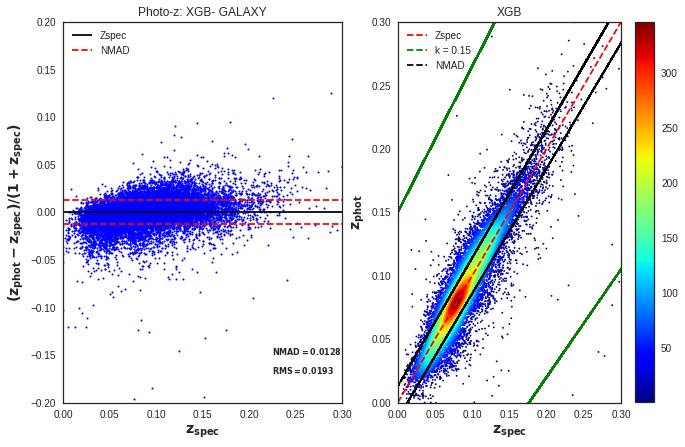

In [43]:
# XGBoost Galaxies

xgb = xgboost.XGBRegressor()


xtrain_xgbg, yztrain_xgbg, ztest_xgbg, zpred_xgbg, xtest_xgbg = regressor(xgb,x_data,y_data, i_gal, i_qso, 'XGB', 'GALAXY', [[0.0,0.3],[-0.2,0.2]])

# QSO

delta(z)_mean = 0.014669612050056458; delta(z)_median = 0.001797444885596633; sigma(delta(z)) = 0.1512743979692459; nmad(delta(z)) = 0.05101582392454147
sigma1 = 7.475459350616663; sigma2 = 2.693178957966272; sigma3 = 1.5605336018122327; sigma5 = 34.35690913667254; sigma10 = 13.818273345079286; sigma15 = 7.500629247420086


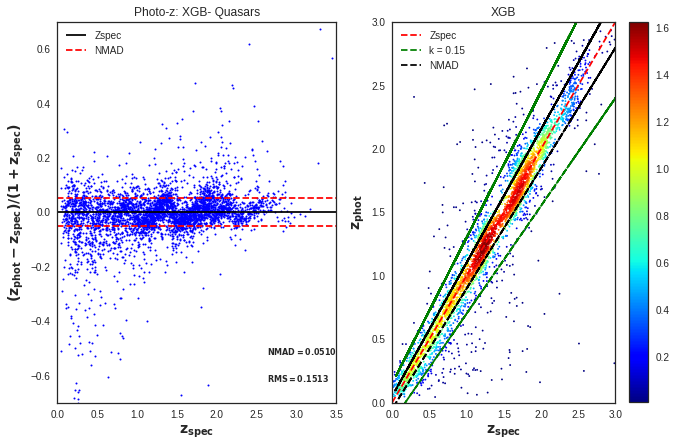

In [53]:
# XGBoost QSO

xtrain_xgbq, yztrain_xgbq, ztest_xgbq, zpred_xgbq, xtest_xgbq = regressor(xgb,x_data,y_data, i_gal, i_qso, 'XGB', '', [[0.0,3.5],[-0.7,0.7]])

In [10]:
# we need to look at the parameters
from pprint import pprint

print('Parameters currently in use: \n')
pprint(xgb.get_params())

Parameters currently in use: 

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'objective': 'reg:squarederror',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}


In [11]:
print(xtest_xgbq[:,1].max())

3.4446887969970703


# OPTIMIZING XGB GALAXIES

In [12]:
# Adopted from https://www.kaggle.com/felipefiorini/xgboost-hyper-parameter-tuning 


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error



#XGBoost hyper-parameter tuning
def hyperParameterTuning_mae(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.15, 0.23, 0.3, 0.45, 0.5],
        'max_depth': [3, 7, 10, 50],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 500, 700, 850, 1000],
        'objective': ['reg:squarederror']
    }

    xgb_model = xgboost.XGBRegressor()

    gsearch = RandomizedSearchCV(estimator = xgb_model,
                           param_distributions = param_tuning,                        
                           scoring = 'neg_median_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           n_iter = 100, cv = 3,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_estimator_


In [13]:
xgb_model_gal = hyperParameterTuning_mae( xtrain_xgbg, yztrain_xgbg )

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/walter/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 48.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 72.6min finished


In [14]:
xgb_model_gal

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [15]:
# model_gal_mae = xgboost.XGBRegressor(subsample= 0.7, n_estimators = 1000, min_child_weight = 1, max_depth = 10, learning_rate = 0.15, colsample_bytree = 0.7)

delta(z)_mean = 0.00042583560571074486; delta(z)_median = 0.00020383372611831874; sigma(delta(z)) = 0.018258167430758476; nmad(delta(z)) = 0.01269258726518601
sigma1 = 18.981012230556118; sigma2 = 3.2164335428069464; sigma3 = 0.6892357591729171; sigma5 = 0.9595242921819042; sigma10 = 0.16893033313061695; sigma15 = 0.10811541320359483


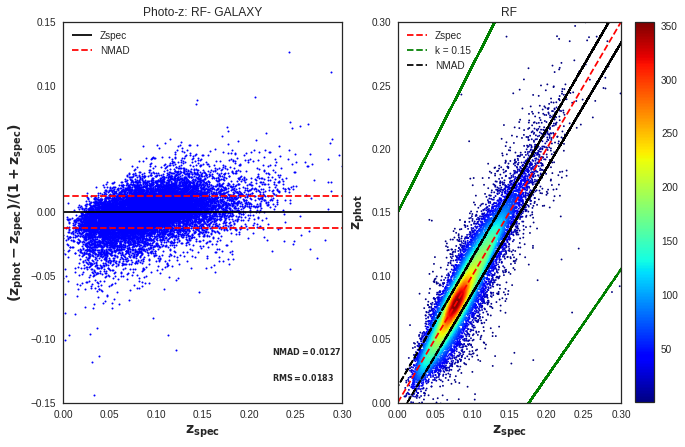

In [17]:
xtrain_xgb_gal, yztrain_xgb_gal, ztest_xgb_gal, zpred_xgb_gal, xtest_xgb_gal = regressor(xgb_model_gal ,x_data,y_data, i_gal, i_qso, 'RF', 'GALAXY', [[0.0,0.3],[-0.15,0.15]])

In [18]:
# Adopted from https://www.kaggle.com/felipefiorini/xgboost-hyper-parameter-tuning 


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error



#XGBoost hyper-parameter tuning
def hyperParameterTuning_rms(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.15, 0.23, 0.3, 0.45, 0.5],
        'max_depth': [3, 7, 10, 50],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 500, 700, 850, 1000],
        'objective': ['reg:squarederror']
    }

    xgb_model = xgboost.XGBRegressor()

    gsearch = RandomizedSearchCV(estimator = xgb_model,
                           param_distributions = param_tuning,                        
#                            scoring = 'neg_median_absolute_error', #MAE
                           scoring = 'neg_mean_squared_error',  #MSE
                           n_iter = 100, cv = 3,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_estimator_


In [19]:
xgb_model_gal_rms = hyperParameterTuning_rms( xtrain_xgbg, yztrain_xgbg )

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/walter/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 41.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 68.0min finished


In [20]:
xgb_model_gal_rms

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=10,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [21]:
# model_gal_rms = xgboost.XGBRegressor(subsample= 0.7, n_estimators = 500, min_child_weight = 3, max_depth = 10, learning_rate = 0.01, colsample_bytree = 0.7)

delta(z)_mean = 0.00030767807038500905; delta(z)_median = 0.00010178210504818708; sigma(delta(z)) = 0.018210407346487045; nmad(delta(z)) = 0.013007748656719923
sigma1 = 19.913507669437124; sigma2 = 3.1015609162781272; sigma3 = 0.7027501858233665; sigma5 = 0.9797959321575782; sigma10 = 0.1554159064801676; sigma15 = 0.06757213325224677


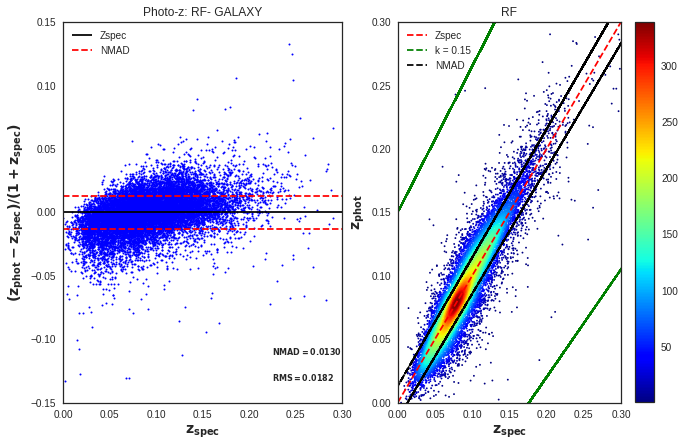

In [22]:
xtrain_xgb_gal_rms, yztrain_xgb_gal_rms, ztest_xgb_gal_rms, zpred_xgb_gal_rms, xtest_xgb_gal_rms = regressor(xgb_model_gal_rms ,x_data,y_data, i_gal, i_qso, 'RF', 'GALAXY', [[0.0,0.3],[-0.15,0.15]])

# RMS and MAE GALAXIES

In [26]:
# RF hyper-parameter tuning using median absolute error as scoring metrix
def model_gal(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.15, 0.23, 0.3, 0.45, 0.5],
        'max_depth': [3, 7, 10, 50],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 500, 700, 850, 1000],
        'objective': ['reg:squarederror']
    }

    xgb_model = xgboost.XGBRegressor()

    Rsearch = RandomizedSearchCV(estimator = xgb_model,
                           param_distributions = param_tuning,                        
                           scoring = 'neg_median_absolute_error', #MAE
                           refit = 'neg_mean_squared_error', 
                           return_train_score = True, #MSE
                           n_iter = 100, cv = 3,
                           n_jobs = -1,
                           verbose = 1)

    Rsearch.fit(X_train,y_train)


    return Rsearch.best_estimator_

In [27]:
best_optim_gal = model_gal(xtrain_xgbg, yztrain_xgbg)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.7min
/home/walter/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 38.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 74.4min finished


In [28]:
best_optim_gal

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=50,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=850, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
# optim_xgb_gal_model = xgboost.XGBRegressor(subsample= 0.5, n_estimators =100, min_child_weight = 1, objective = 'reg:squarederror', max_depth = 10, learning_rate = 0.15, colsample_bytree = 0.7)

delta(z)_mean = 0.0005168044590391219; delta(z)_median = 0.00015874400560278445; sigma(delta(z)) = 0.018554702401161194; nmad(delta(z)) = 0.012892968653328715
sigma1 = 18.670180417595784; sigma2 = 3.013717143050206; sigma3 = 0.7568078924251639; sigma5 = 1.087911345361173; sigma10 = 0.1554159064801676; sigma15 = 0.09460098655314549


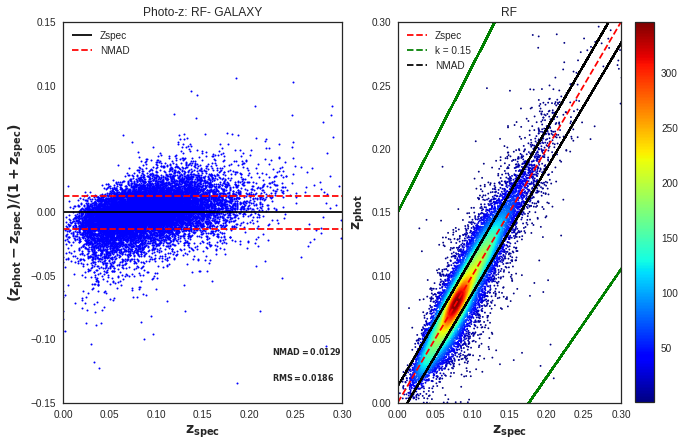

In [32]:
xtrain_xgb_gal_mod1, yztrain_xgb_gal_mod1, ztest_xgb_gal_mod1, zpred_xgb_gal_mod1, xtest_xgbq_gal_mod1 = regressor(best_optim_gal ,x_data,y_data, i_gal, i_qso, 'RF', 'GALAXY', [[0.0,0.3],[-0.15,0.15]])

In [41]:
# Colour to error plot
def colour_normz_plot_gal(r, ztest, zpred, name):
#     calling the photo_z statz defined above
    del_z_norm, del_z_mean, del_z_median, del_z_RMS, del_z_MAD, del_z_NMAD = photo_z_stats(zpred,ztest)
    
#     making a plot
    pl.figure(figsize=(7,7))
    pl.scatter(r, del_z_norm, lw=0.2,s=5, color = 'b')
    
    
    pl.hlines(0.0, 10, 25, colors='k',linestyle='solid', label = 'Zspec')
    
    pl.hlines(del_z_MAD, 10, 25,colors='r',linestyle='dashed')
    pl.hlines(-del_z_MAD, 10, 25,colors='r',linestyle='dashed', label = 'NMAD')
    
#     multiplying nmad by 3
    pl.hlines(0.05, 10, 25,colors='g',linestyle='dashed')
    pl.hlines(-0.05, 10, 25,colors='g',linestyle='dashed', label = 'k = 0.05')
    
    pl.xlabel('r')
    pl.ylabel('(z_phot-z_spec)/(1+zspec)')
    pl.ylim(-0.15, 0.15)
    pl.xlim(14, 20)
    pl.title('Photo-z vs r-mag: ' + name + '- Galaxies')
    pl.legend()


delta(z)_mean = 0.0005168045172467828; delta(z)_median = 0.00015874400560278445; sigma(delta(z)) = 0.018554702401161194; nmad(delta(z)) = 0.012892968653328715


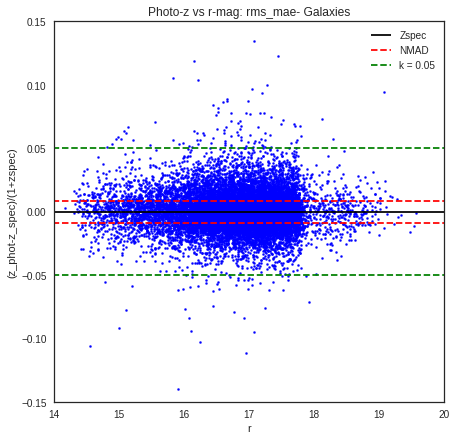

In [42]:
colour_normz_plot_gal( xtest_xgbq_gal_mod1[:,0], ztest_xgb_gal_mod1, zpred_xgb_gal_mod1, 'rms_mae')

# QSO optimization

In [44]:
from sklearn.model_selection import cross_val_score
from sklearn import svm, datasets
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

In [47]:
# XGB hyper-parameter tuning using median absolute error as scoring metrix
def hyperParameterTuning_mae_qso(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.15, 0.23, 0.3, 0.45, 0.5],
        'max_depth': [3, 7, 10, 50],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 500, 700, 850, 1000],
        'objective': ['reg:squarederror']
    }

    xgb_model = xgboost.XGBRegressor()

    Rsearch = RandomizedSearchCV(estimator = xgb_model,
                           param_distributions = param_tuning,                        
                           scoring = 'neg_median_absolute_error', #MAE
#                            scoring = 'neg_mean_squared_error',  #MSE
                           n_iter = 100, cv = 3,
                           n_jobs = -1,
                           verbose = 1)

    Rsearch.fit(X_train,y_train)


    return Rsearch.best_estimator_

In [54]:
# Using the RandomizedSearchCV to find the best parameter setting for qso
opt_xgb_mae_qso = hyperParameterTuning_mae_qso(xtrain_xgbq, yztrain_xgbq)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/walter/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 20.1min finished


In [55]:
opt_xgb_mae_qso

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=700, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [56]:
# qso_xgb_model_mae = xgboost.XGBRegressor(subsample= 0.7, n_estimators = 700, min_child_weight = 1, max_depth = 7, learning_rate = 0.01, colsample_bytree = 0.7)

delta(z)_mean = 0.01721774786710739; delta(z)_median = 0.0016476679593324661; sigma(delta(z)) = 0.13463905453681946; nmad(delta(z)) = 0.05052741483002901
sigma1 = 9.791089856531588; sigma2 = 3.4734457588723884; sigma3 = 1.7618927762396173; sigma5 = 34.40724893027939; sigma10 = 14.01963251950667; sigma15 = 8.004027183488548


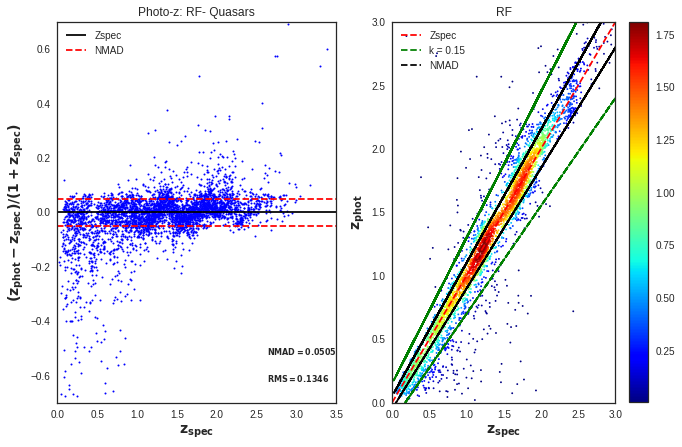

In [57]:
xtrain_xgb_qso_mod1, yztrain_xgb_qso_mod1, ztest_xgb_qso_mod1, zpred_xgb_qso_mod1, xtest_xgbq_qso_mod1 = regressor(opt_xgb_mae_qso, x_data,y_data, i_gal, i_qso, 'RF', '', [[0.0,3.5],[-0.7,0.7]])

In [58]:
# Colour to error plot
def colour_normz_plot(r, ztest, zpred, name):
#     calling the photo_z statz defined above
    del_z_norm, del_z_mean, del_z_median, del_z_RMS, del_z_MAD, del_z_NMAD = photo_z_stats(zpred,ztest)
    
#     making a plot
    pl.figure(figsize=(7,7))
    pl.scatter(r, del_z_norm, lw=0.2,s=5, color = 'b')
    
    
    pl.hlines(0.0, 10, 25, colors='k',linestyle='solid', label = 'Zspec')
    
    pl.hlines(del_z_MAD, 10, 25,colors='r',linestyle='dashed')
    pl.hlines(-del_z_MAD, 10, 25,colors='r',linestyle='dashed', label = 'NMAD')
    
#     multiplying nmad by 3
    pl.hlines(0.15, 10, 25,colors='g',linestyle='dashed')
    pl.hlines(-0.15, 10, 25,colors='g',linestyle='dashed', label = 'k = 0.15')
    
    pl.xlabel('r')
    pl.ylabel('(z_phot-z_spec)/(1+zspec)')
    pl.ylim(-1, 1)
    pl.xlim(16, 20)
    pl.title('Photo-z vs r-mag: ' + name + '- Quasars')
    pl.legend()


delta(z)_mean = 0.01721774786710739; delta(z)_median = 0.0016476679593324661; sigma(delta(z)) = 0.13463905453681946; nmad(delta(z)) = 0.05052741483002901


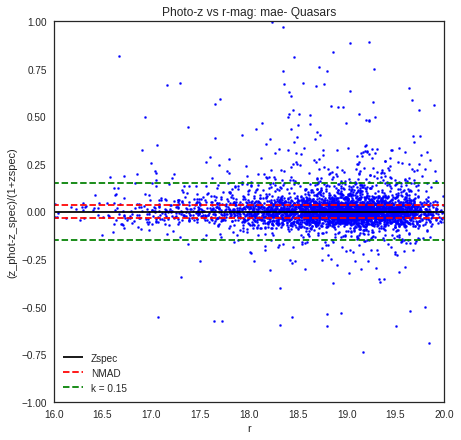

In [59]:
colour_normz_plot(xtest_xgbq_qso_mod1[:,0], ztest_xgb_qso_mod1, zpred_xgb_qso_mod1, 'mae')

In [61]:
# RF hyper-parameter tuning using rms as scoring metrix
def hyperParameterTuning_rms_qso(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.15, 0.23, 0.3, 0.45, 0.5],
        'max_depth': [3, 7, 10, 50],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 500, 700, 850, 1000],
        'objective': ['reg:squarederror']
    }

    xgb_model = xgboost.XGBRegressor()

    Rsearch = RandomizedSearchCV(estimator = xgb_model,
                           param_distributions = param_tuning,                        
#                            scoring = 'neg_median_absolute_error', #MAE
                           scoring = 'neg_mean_squared_error',  #MSE
                           n_iter = 100, cv = 3,
                           n_jobs = -1,
                           verbose = 1)

    Rsearch.fit(X_train,y_train)


    return Rsearch.best_estimator_

In [62]:
# Using the RandomizedSearchCV to find the best parameter setting for galaxies
qso_xgb_model_rms = hyperParameterTuning_rms_qso(xtrain_xgbq, yztrain_xgbq)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
/home/walter/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 17.4min finished


In [28]:
qso_xgb_model_rms

{'subsample': 0.7,
 'objective': 'reg:squarederror',
 'n_estimators': 1000,
 'min_child_weight': 5,
 'max_depth': 10,
 'learning_rate': 0.01,
 'colsample_bytree': 0.7}

In [29]:
# qso_xgb_model_rms_reg = xgboost.XGBRegressor(subsample= 0.7, n_estimators = 1000, min_child_weight = 5, max_depth = 10, learning_rate = 0.01, colsample_bytree = 0.7)

delta(z)_mean = 0.01506742462515831; delta(z)_median = 0.0016352434176951647; sigma(delta(z)) = 0.12465585768222809; nmad(delta(z)) = 0.05700012497976422
sigma1 = 12.15706015605336; sigma2 = 4.2033727661716584; sigma3 = 2.0135917442738482; sigma5 = 39.18952932292978; sigma10 = 16.637301787062672; sigma15 = 9.539390888497357


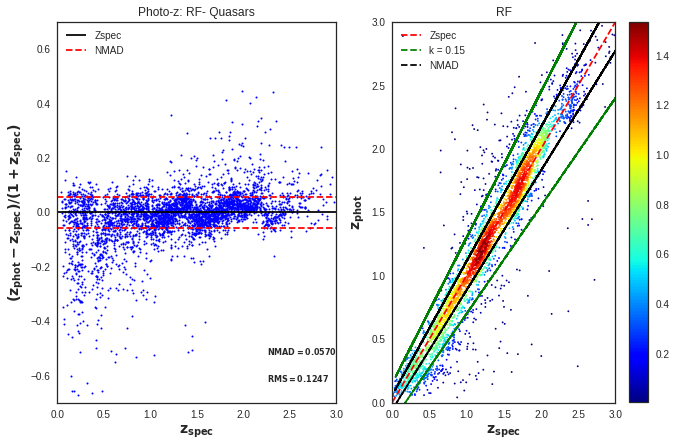

In [63]:
xtrain_xgb_qso_mod2, yztrain_xgb_qso_mod2, ztest_xgb_qso_mod2, zpred_xgb_qso_mod2, xtest_xgbq_qso_mod2 = regressor(qso_xgb_model_rms, x_data,y_data, i_gal, i_qso, 'RF', '', [[0.0,3.0],[-0.7,0.7]])

delta(z)_mean = 0.015067425556480885; delta(z)_median = 0.0016352434176951647; sigma(delta(z)) = 0.12465585768222809; nmad(delta(z)) = 0.05700012497976422


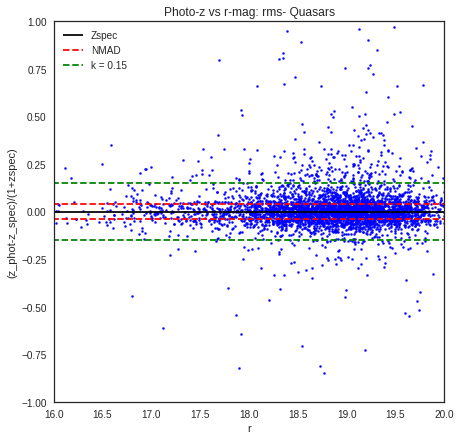

In [64]:
colour_normz_plot(xtest_xgbq_qso_mod2[:,0], ztest_xgb_qso_mod2, zpred_xgb_qso_mod2,'rms')

# MAKING TWO SCORES

In [67]:
# RF hyper-parameter tuning using median absolute error as scoring metrix
def model_rms_mae_gal12(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.15, 0.23, 0.3, 0.45, 0.5],
        'max_depth': [3, 7, 10, 50],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 500, 700, 850, 1000],
        'objective': ['reg:squarederror']
    }

    xgb_model = xgboost.XGBRegressor()

    Rsearch = RandomizedSearchCV(estimator = xgb_model,
                           param_distributions = param_tuning,                        
                           scoring = 'neg_median_absolute_error', #MAE
                           refit = 'neg_mean_squared_error', 
                           return_train_score = True, #MSE
                           n_iter = 100, cv = 3,
                           n_jobs = -1,
                           verbose = 1)

    Rsearch.fit(X_train,y_train)


    return Rsearch.best_estimator_

In [68]:
best_optim = model_rms_mae_gal12(xtrain_xgbq, yztrain_xgbq)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/walter/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 21.7min finished


In [35]:
best_optim

{'subsample': 0.7,
 'objective': 'reg:squarederror',
 'n_estimators': 1000,
 'min_child_weight': 1,
 'max_depth': 10,
 'learning_rate': 0.01,
 'colsample_bytree': 0.7}

In [36]:
# optim_xgb_model = xgboost.XGBRegressor(subsample= 0.7, n_estimators = 1000, min_child_weight = 1, objective = 'reg:squarederror', max_depth = 10, learning_rate = 0.01, colsample_bytree = 0.7)

delta(z)_mean = 0.012226570397615433; delta(z)_median = -0.0003072289691772312; sigma(delta(z)) = 0.11481940746307373; nmad(delta(z)) = 0.05295858528837561
sigma1 = 12.584948401711554; sigma2 = 4.78228039265039; sigma3 = 2.2904606091115025; sigma5 = 36.571860055373776; sigma10 = 15.101938082053865; sigma15 = 8.859803674804933


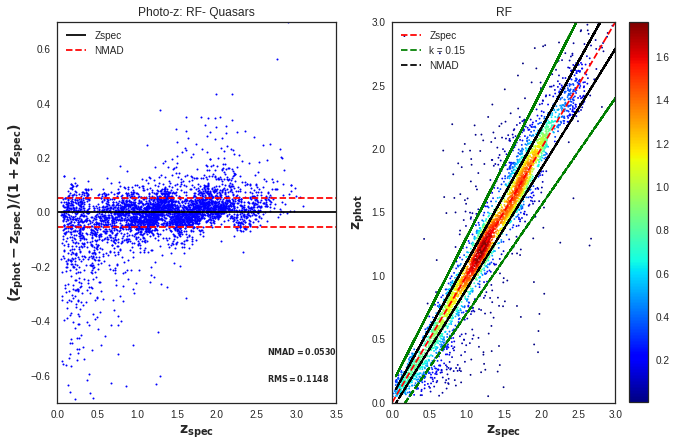

In [69]:
xtrain_xgb_qso_mod3, yztrain_xgb_qso_mod3, ztest_xgb_qso_mod3, zpred_xgb_qso_mod3, xtest_xgbq_qso_mod3 = regressor(best_optim, x_data,y_data, i_gal, i_qso, 'RF', '', [[0.0,3.5],[-0.7,0.7]])

delta(z)_mean = 0.012226572260260582; delta(z)_median = -0.0003072289691772312; sigma(delta(z)) = 0.11481940001249313; nmad(delta(z)) = 0.05295858528837561


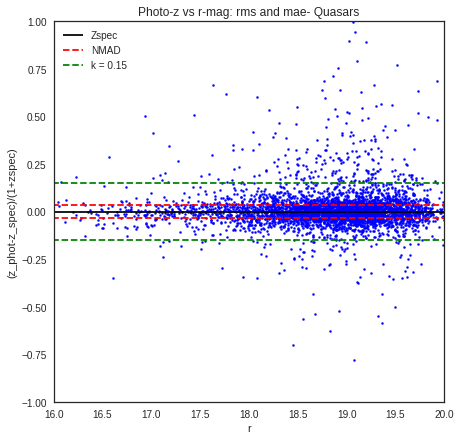

In [70]:
colour_normz_plot(xtest_xgbq_qso_mod3[:,0], ztest_xgb_qso_mod3, zpred_xgb_qso_mod3, 'rms and mae')